In [1]:
import pathlib
import cv2
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from copy import deepcopy

In [5]:
# BODY_25 Output Format
keypointsMapping = {
    0: 'Nose',
    1: 'Neck',
    2: 'RShoulder',
    3: 'RElbow',
    4: 'RWrist',
    5: 'LShoulder',
    6: 'LElbow',
    7: 'LWrist',
    8: 'MidHip',
    9: 'RHip',
    10: 'RKnee',
    11: 'RAnkle',
    12: 'LHip',
    13: 'LKnee',
    14: 'LAnkle',
    15: 'REye',
    16: 'LEye',
    17: 'REar',
    18: 'LEar',
    19: "LBigToe",
    20: "LSmallToe",
    21: "LHeel",
    22: "RBigToe",
    23: "RSmallToe",
    24: "RHeel",
    25: "Background"
}

# パスの宣言

In [3]:
# path
root_dir = pathlib.Path("../../data/fashion550k").resolve()
original_csv_path = root_dir / "dataframe/dataframe.csv"
# 対象はデータ選択1-2のデータセット
csv_path = root_dir / "dataframe/selection1-2/selection05-04_df.csv"
save_dir = pathlib.Path("make_map4selection05-04")
if not save_dir.exists():
    save_dir.mkdir()
# データ選択０で指定されたデータフレーム
df = pd.read_csv(csv_path)
print("データ数:", len(df))
df.head()

データ数: 211080


img_path  \
0  /home/yohei/Documents/tlab/data/fashion550k/ph...   
1  /home/yohei/Documents/tlab/data/fashion550k/ph...   
2  /home/yohei/Documents/tlab/data/fashion550k/ph...   
3  /home/yohei/Documents/tlab/data/fashion550k/ph...   
4  /home/yohei/Documents/tlab/data/fashion550k/ph...   

                                       keypoint_path  \
0  /home/yohei/Documents/tlab/data/fashion550k/an...   
1  /home/yohei/Documents/tlab/data/fashion550k/an...   
2  /home/yohei/Documents/tlab/data/fashion550k/an...   
3  /home/yohei/Documents/tlab/data/fashion550k/an...   
4  /home/yohei/Documents/tlab/data/fashion550k/an...   

                                     visualized_path  
0  /home/yohei/Documents/tlab/data/fashion550k/an...  
1  /home/yohei/Documents/tlab/data/fashion550k/an...  
2  /home/yohei/Documents/tlab/data/fashion550k/an...  
3  /home/yohei/Documents/tlab/data/fashion550k/an...  
4  /home/yohei/Documents/tlab/data/fashion550k/an...

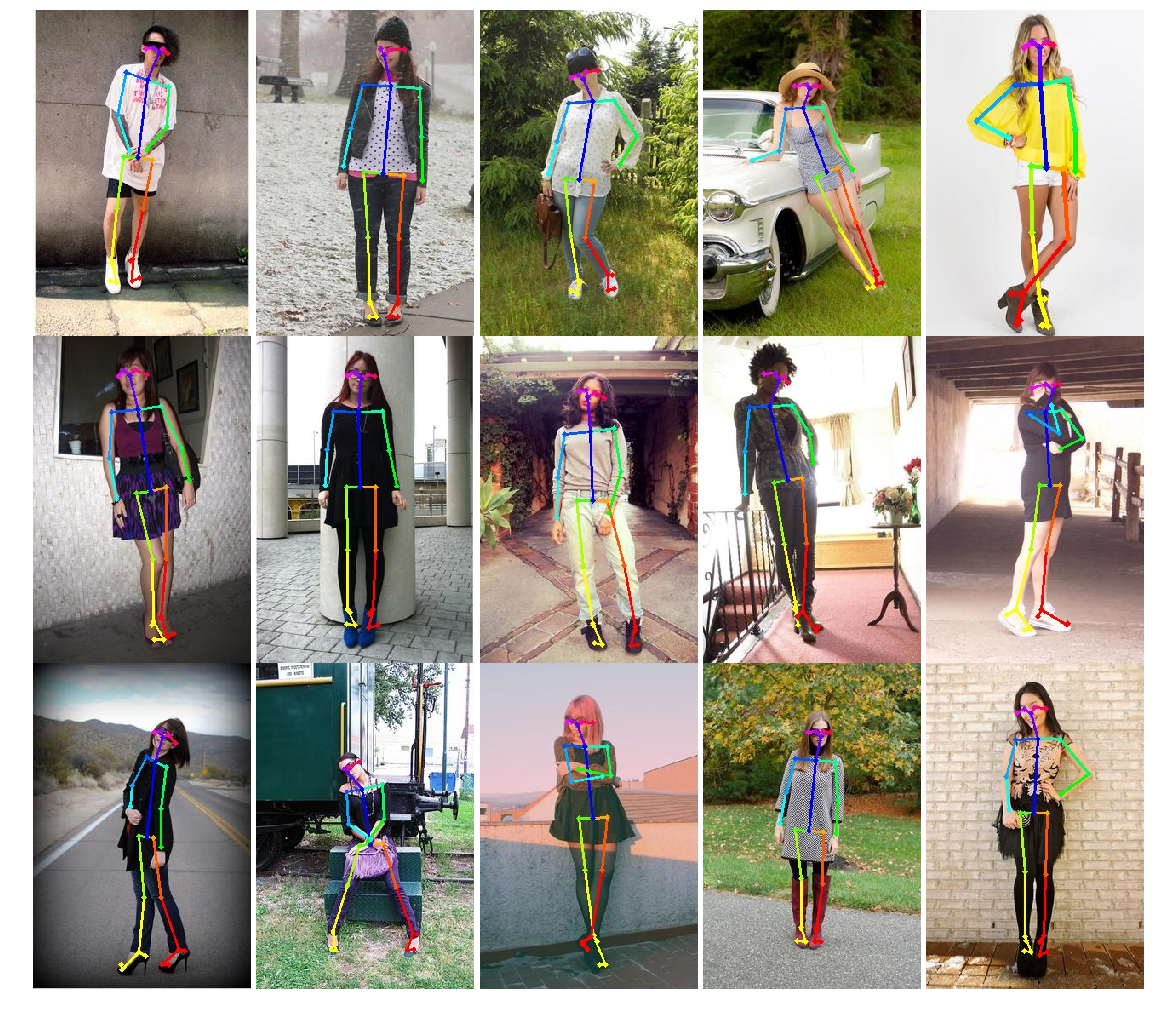

In [6]:
# データを可視化して確認
fig, axes = plt.subplots(3, 5, figsize=(20, 18))
for (i, (_, _, visualized_path)), ax in zip(df.iterrows(), axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(visualized_path)), cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_axis_off()
plt.subplots_adjust(hspace=0, wspace=0)

# 入力マップのたたき台

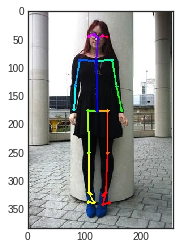

In [49]:
_, keypoint_path, vis_path = df.iloc[6]
img = cv2.cvtColor(cv2.imread(str(vis_path)), cv2.COLOR_BGR2RGB)
keypoint = np.load(keypoint_path)
plt.imshow(img)

In [44]:
# 注目する部分
attention = sorted([0, 1, 2, 3, 5, 6, 8, 9, 10, 12, 13] + [4, 7, 11, 14])
for a in attention:
    print(keypointsMapping[a], end=", ")


Nose, Neck, RShoulder, RElbow, RWrist, LShoulder, LElbow, LWrist, MidHip, RHip, RKnee, RAnkle, LHip, LKnee, LAnkle, 

(384, 256)

In [83]:
attention

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

768 512


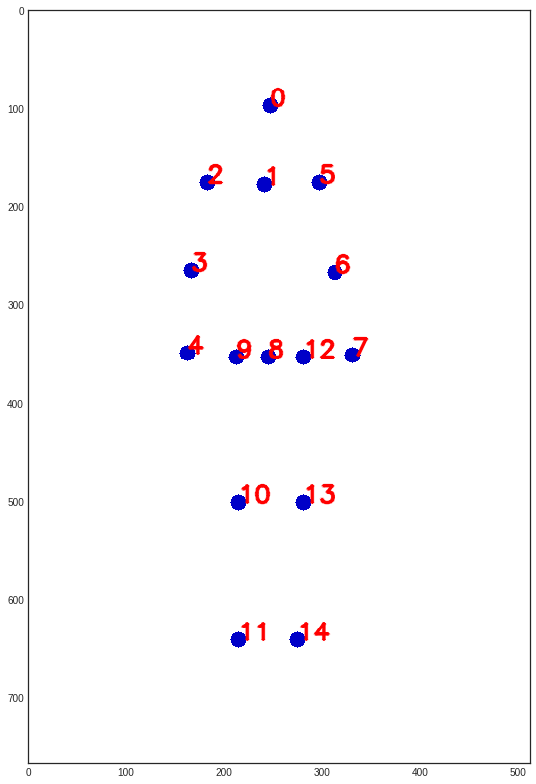

In [93]:
h, w = img.shape[:-1]
scale = 2
h, w = h * scale, w * scale  # 見やすくするためにスケール
print(h, w)

color = (0, 0, 200)
#example = np.full_like(img, fill_value=255)
example = np.full((h, w, 3), fill_value=255, dtype=img.dtype)
plt.figure(figsize=(9, 18))
for (x, y, _), i in zip(keypoint[0, attention], attention):
    x, y = int(np.rint(x)) * scale, int(np.rint(y)) * scale
    cv2.circle(example, (x, y), 8, color, thickness=-1)
    cv2.putText(example,
                "{}".format(i), (x, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (255, 0, 0),
                2,
                lineType=cv2.LINE_AA)
plt.imshow(example)

## 顔部分
楕円で表現
- 長径（Nose:0 から Neck:1 の長さ） 短径（Nose:0 から Neck:1 の長さの半分）

[注意]  
下を向いた場合ではこの方法は微妙？そこまで神経質にマップを考える必要はない気がする．

In [234]:
attention

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [235]:
# 顔部分は 長径（Nose:0 から Neck:1） 短径（Nose:0 から Neck:1）
nose = np.rint(keypoint[0, attention[0], :-1]).astype(int)
neck = np.rint(keypoint[0, attention[1], :-1]).astype(int)
nose, neck

(array([123,  49]), array([120,  89]))

In [10]:
def theta2theta(theta):
    """
    角度のとりかたを変換する関数
    
    theta : ラジアン，np.arctan2より得られる角度
    """
    # まず，theta が負であれば，対応する正の角度へ変換．180 を足す.
    if theta < 0:
        theta = theta + 180

    # 新しい角度へ変換
    if theta <= 90:
        new_theta = 90 - theta
    else:
        new_theta = 270 - theta
    
    return new_theta

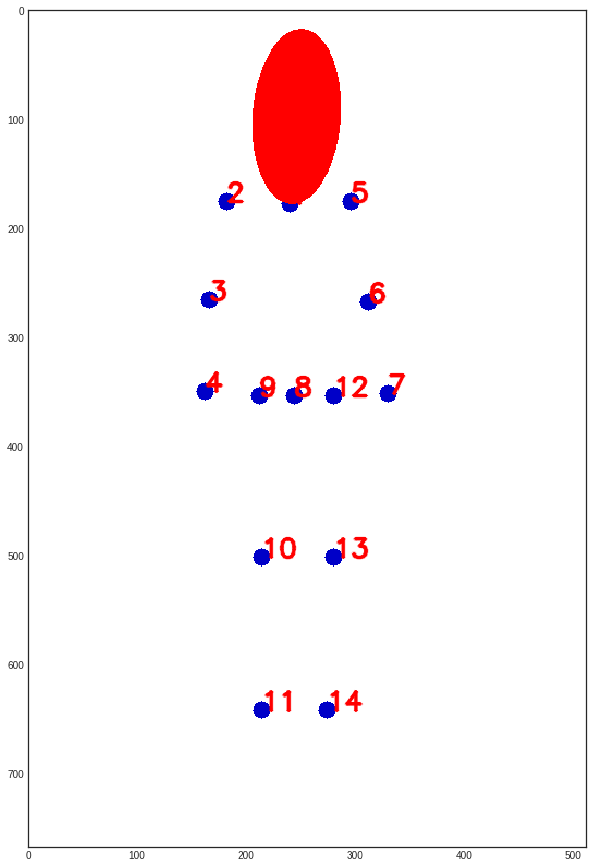

In [236]:
tmp = deepcopy(example)
vector = nose*2 - neck*2
theta = np.rad2deg(np.arctan2(-vector[1], vector[0]))
plt.figure(figsize=(10, 20))
long = int(linalg.norm(vector))
short = long // 2
cv2.ellipse(tmp, (nose[0] * scale, nose[1] * scale), (short, long),
            angle=theta2theta(theta),
            startAngle=0,
            endAngle=360,
            color=(255, 0, 0),
            thickness=-1)
plt.imshow(tmp)

## 胴体以外

In [199]:
attention

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [202]:
# 右肘と右手首に注目
keypointsMapping[3], keypointsMapping[4]

('RElbow', 'RWrist')

In [209]:
relbow = np.rint(keypoint[0, attention[3], :-1]).astype(int)
rwrist = np.rint(keypoint[0, attention[4], :-1]).astype(int)
relbow, rwrist

(array([ 83, 133]), array([ 81, 175]))

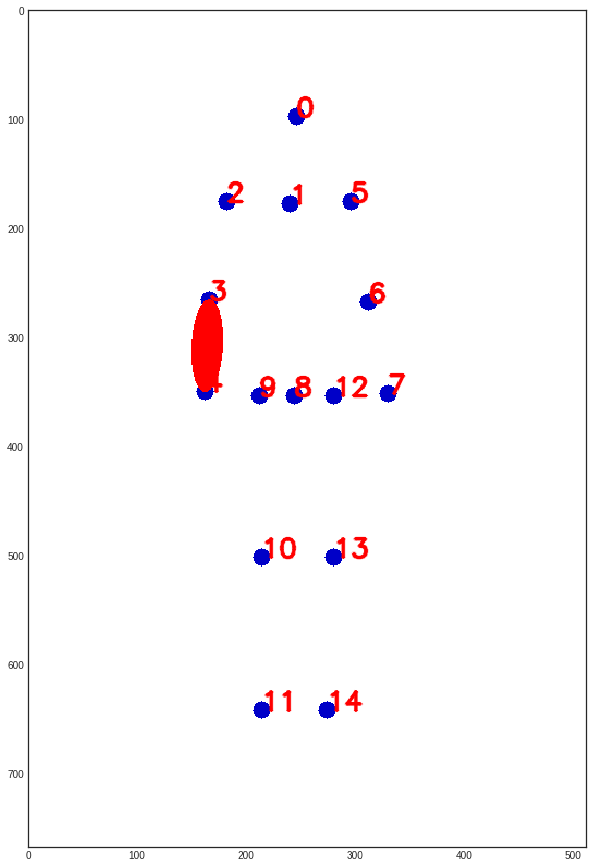

In [232]:
tmp = deepcopy(example)
center = (relbow*scale + rwrist*scale)//2
vector = rwrist*scale - center
theta = np.rad2deg(np.arctan2(-vector[1], vector[0]))
plt.figure(figsize=(10, 20))
long = int(linalg.norm(vector))
short = long // 3
#short = 7*scale
cv2.ellipse(tmp, (center[0], center[1]), (short, long),
            angle=theta2theta(theta),
            startAngle=0,
            endAngle=360,
            color=(255, 0, 0),
            thickness=-1)
plt.imshow(tmp)

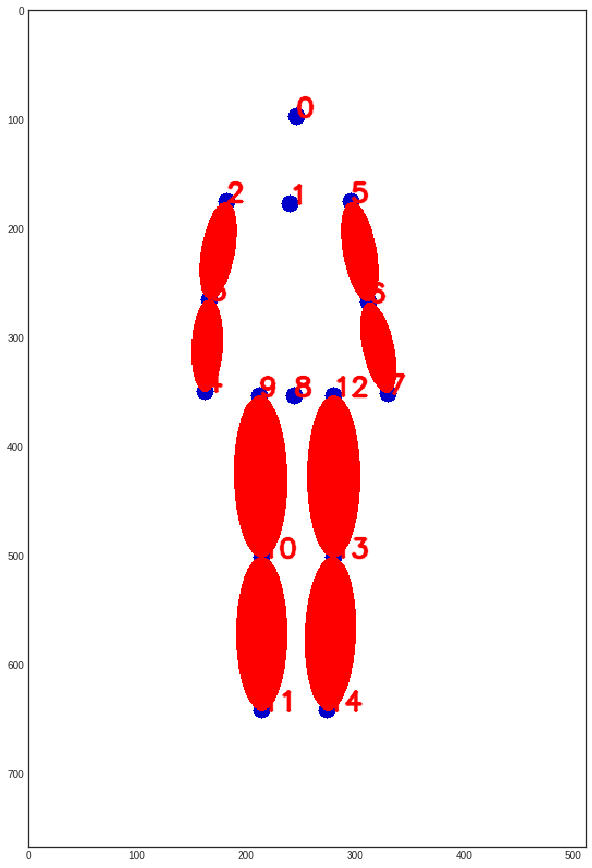

In [237]:
# 他の点についても全て
pair = [[2, 3], [3, 4], [5, 6], [6, 7], [9, 10], [10, 11], [12, 13], [13, 14]]
tmp = deepcopy(example)
for pair1, pair2 in pair:
    # 顔部分は 長径（Nose:0 から Neck:1） 短径（Nose:0 から Neck:1）
    point1 = np.rint(keypoint[0, attention[pair1], :-1]).astype(int)
    point2 = np.rint(keypoint[0, attention[pair2], :-1]).astype(int)

    center = (point1*scale + point2*scale)//2
    vector = point1*scale - center
    theta = np.rad2deg(np.arctan2(-vector[1], vector[0]))

    long = int(linalg.norm(vector))
    short = long // 3
    cv2.ellipse(tmp, (center[0], center[1]), (short, long),
                angle=theta2theta(theta),
                startAngle=0,
                endAngle=360,
                color=(255, 0, 0),
                thickness=-1)
plt.figure(figsize=(10, 20))
plt.imshow(tmp)

## 胴体

In [217]:
attention

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [218]:
keypointsMapping

{0: 'Nose',
 1: 'Neck',
 2: 'RShoulder',
 3: 'RElbow',
 4: 'RWrist',
 5: 'LShoulder',
 6: 'LElbow',
 7: 'LWrist',
 8: 'MidHip',
 9: 'RHip',
 10: 'RKnee',
 11: 'RAnkle',
 12: 'LHip',
 13: 'LKnee',
 14: 'LAnkle',
 15: 'REye',
 16: 'LEye',
 17: 'REar',
 18: 'LEar',
 19: 'LBigToe',
 20: 'LSmallToe',
 21: 'LHeel',
 22: 'RBigToe',
 23: 'RSmallToe',
 24: 'RHeel',
 25: 'Background'}

In [219]:
neck, rShoulder, lShoulder, midHip, rHip, lHip = attention[1], attention[
    2], attention[5], attention[8], attention[9], attention[12]
print(keypointsMapping[neck], keypointsMapping[rShoulder],
      keypointsMapping[lShoulder], keypointsMapping[midHip],
     keypointsMapping[rHip], keypointsMapping[lHip])

Neck RShoulder LShoulder MidHip RHip LHip


In [228]:
list_ = [rShoulder, neck, lShoulder, lHip, midHip, rHip]  # 順番が大切
points = []
for i in list_:
    points.append(np.rint(keypoint[0, i, :-1]).astype(int))
points = np.asarray(points) * scale

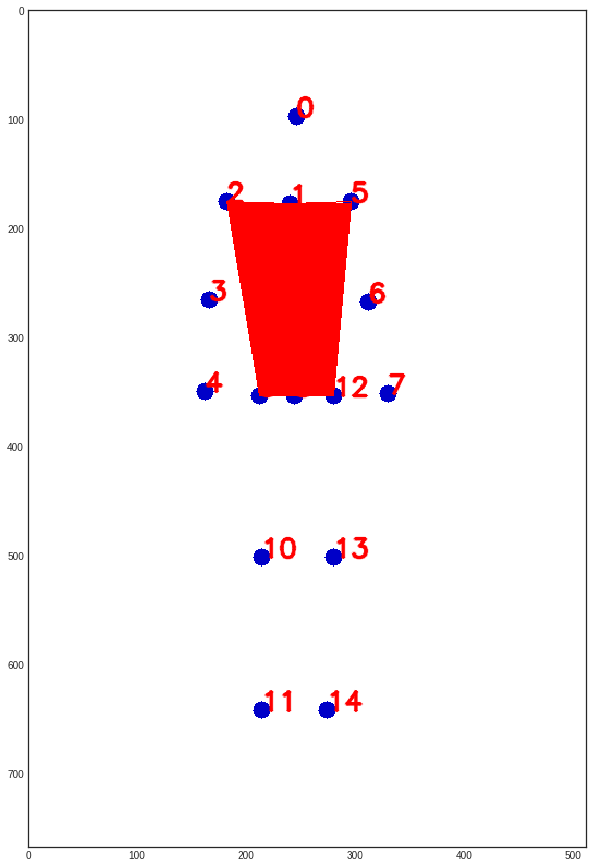

In [230]:
tmp = deepcopy(example)
cv2.fillConvexPoly(tmp, points=points, color=(255, 0, 0))
plt.figure(figsize=(10, 20))
plt.imshow(tmp)

## 全身でやってみる

In [37]:
# 注目する部分
attention = sorted([0, 1, 2, 3, 5, 6, 8, 9, 10, 12, 13] + [4, 7, 11, 14])
colors = [[0, 50, 255], [130, 40, 255], [0, 128, 128], [0, 128, 0], [0, 255, 0],
          [0, 255, 255], [255, 255, 0], [255, 0, 0], [255, 0, 255],
          [128, 0, 128]]


def keypoint2segmap(keypoint, img, scale=1):
    """
    keypointを荒いsegmapへ変換する
    """

    # 顔部分
    segmap = np.full_like(img, fill_value=0)
    nose = np.rint(keypoint[0, attention[0], :-1]).astype(int)
    neck = np.rint(keypoint[0, attention[1], :-1]).astype(int)
    vector = nose * scale - neck * scale
    theta = np.rad2deg(np.arctan2(-vector[1], vector[0]))
    long = int(linalg.norm(vector))
    short = long // 2
    cv2.ellipse(segmap, (nose[0] * scale, nose[1] * scale), (short, long),
                angle=theta2theta(theta),
                startAngle=0,
                endAngle=360,
                color=colors[0],
                thickness=-1)

    # 胴体
    neck, rShoulder, lShoulder, midHip, rHip, lHip = attention[1], attention[
        2], attention[5], attention[8], attention[9], attention[12]
    list_ = [rShoulder, neck, lShoulder, lHip, midHip, rHip]  # 順番が大切
    points = []
    for i in list_:
        points.append(np.rint(keypoint[0, i, :-1]).astype(int))
    points = np.asarray(points) * scale
    cv2.fillConvexPoly(segmap, points=points, color=colors[1])

    # 胴体以外
    pair = [[2, 3], [3, 4], [5, 6], [6, 7], [9, 10], [10, 11], [12, 13],
            [13, 14]]
    for i, (pair1, pair2) in enumerate(pair):
        point1 = np.rint(keypoint[0, attention[pair1], :-1]).astype(int)
        point2 = np.rint(keypoint[0, attention[pair2], :-1]).astype(int)

        center = (point1 * scale + point2 * scale) // 2
        vector = point1 * scale - center
        theta = np.rad2deg(np.arctan2(-vector[1], vector[0]))

        long = int(linalg.norm(vector))
        tmp = [pair1, pair2]
        if tmp == [2, 3] or tmp == [3, 4] or tmp == [5, 6] or tmp == [6, 7]:
            #short = int(long / 3)
            short = long // 2
        else:
            short = long // 3
        cv2.ellipse(segmap, (center[0], center[1]), (short, long),
                    angle=theta2theta(theta),
                    startAngle=0,
                    endAngle=360,
                    color=colors[i + 2],
                    thickness=-1)
    return segmap

## 重ねてみる

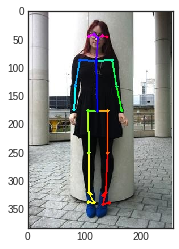

In [38]:
_, keypoint_path, vis_path = df.iloc[6]
img = cv2.cvtColor(cv2.imread(str(vis_path)), cv2.COLOR_BGR2RGB)
keypoint = np.load(keypoint_path)
plt.imshow(img)

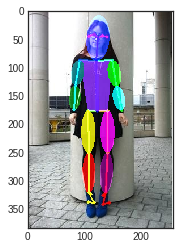

In [39]:
segmap = keypoint2segmap(keypoint, img)
tmp = cv2.addWeighted(img, 1, segmap, 0.8, 0)
plt.imshow(tmp)

# 全データで考える

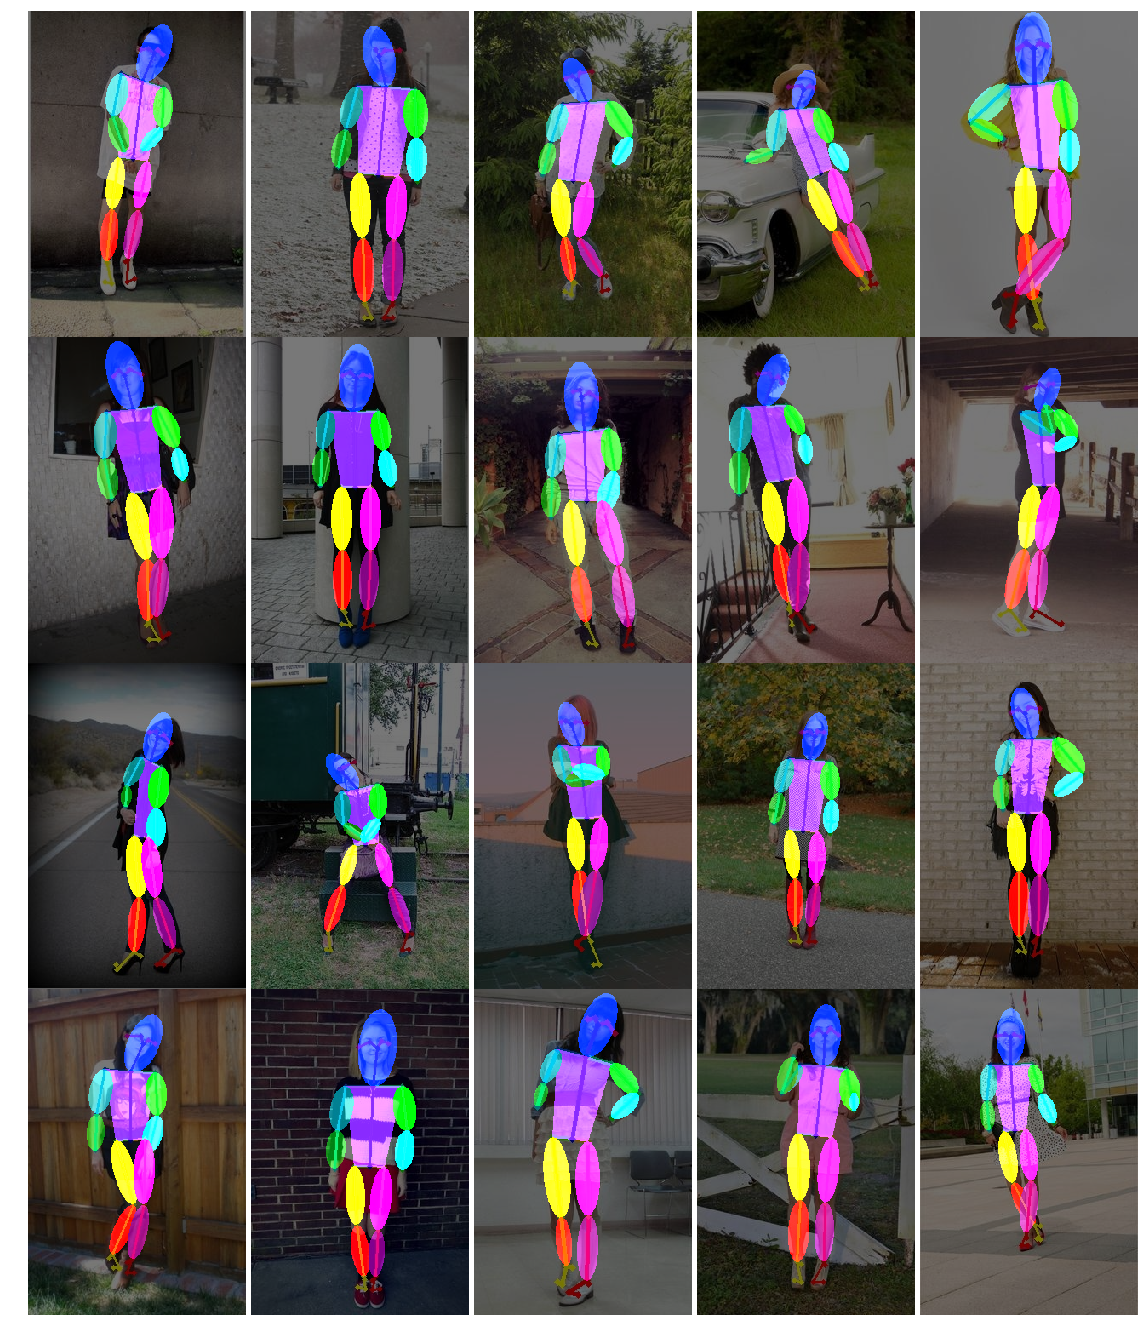

In [45]:
# データを可視化して確認
fig, axes = plt.subplots(4, 5, figsize=(20, 24))
for (i, (_, keypoint_path,
         visualized_path)), ax in zip(df.iterrows(), axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(visualized_path)), cv2.COLOR_BGR2RGB)
    keypoint = np.load(keypoint_path)
    segmap = keypoint2segmap(keypoint, img)
    tmp = cv2.addWeighted(img, 0.47, segmap, 1, 0)
    ax.imshow(tmp)
    ax.set_axis_off()
plt.subplots_adjust(hspace=0, wspace=0)
fig.savefig(save_dir / "example_map.png", bbox_inches="tight", pad_inches=0)

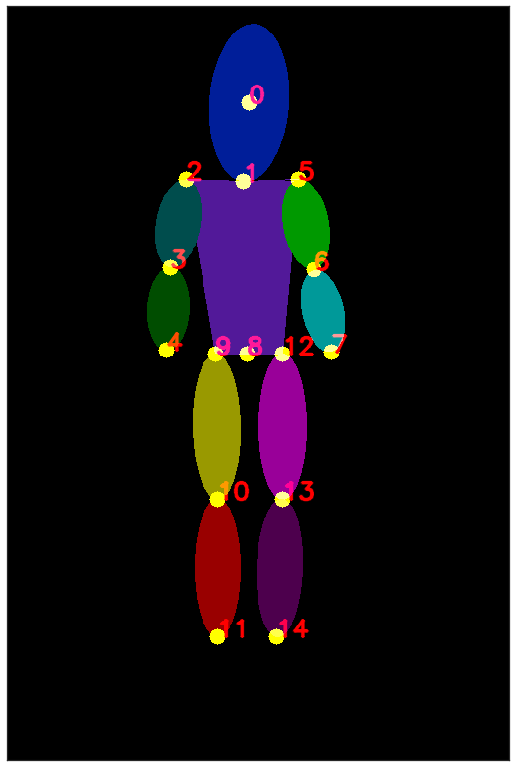

In [46]:
# 姿勢マップを保存
_, keypoint_path, _ = df.iloc[6]
scale=2
keypoint = np.load(keypoint_path)
h, w = 384*scale,256*scale
example = np.full((h, w, 3), fill_value=0, dtype=img.dtype)
plt.figure(figsize=(9, 18))
for (x, y, _), i in zip(keypoint[0, attention], attention):
    x, y = int(np.rint(x)) * scale, int(np.rint(y)) * scale
    cv2.circle(example, (x, y), 8, (255, 255,0), thickness=-1)
    cv2.putText(example,
                "{}".format(i), (x, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (255, 0, 0),
                2,
                lineType=cv2.LINE_AA)
img = np.zeros((h,w,3)).astype("uint8")
segmap = keypoint2segmap(keypoint, img, scale=scale)
tmp = cv2.addWeighted(segmap, 0.6, example, 1, 0)
plt.imshow(tmp)
plt.xticks([])
plt.yticks([])
plt.savefig(save_dir / "segmap.png", bbox_inches="tight", pad_inches=0)